In [15]:
import pandas as pd
import pyarrow.dataset as pqds
from pyarrow import fs
import pyarrow as pa
import math

In [16]:
data_path = "data/kraken.ETHUSD"
data_set_index = "dsindex"
begin_partition:int = 202201
end_partition:int = 202303
# Read parquet file from data_path as pyarrown dateset
dataset: pqds.dataset = pqds.dataset(
            data_path,
            format="parquet",
            partitioning="hive",
            filesystem=fs.LocalFileSystem(),
        )

criteria = (pqds.field(data_set_index) >= begin_partition) & (
            pqds.field(data_set_index) <= end_partition
        )
dt: pa.table = dataset.to_table(filter=criteria)
df: pd.DataFrame = dt.to_pandas()
#Make column timestamp as pandas datetime index
df.set_index("timestamp", inplace=True)
#convert timestamp ms to datetime
df.index = pd.to_datetime(df.index, unit="ms")
# Resample candlestick to 60 minutes in length
df = df.resample("15Min").agg({"open": "first", "high": "max", "low": "min", "close": "last", "volume": "sum"})
# Remove any rows with NaN values
df.dropna(inplace=True)

In [17]:
df.head()

,open,high,low,close,volume
timestamp,,,,,
2022-01-01 00:00:00,3675.95,3702.03,3675.95,3692.80,217.362166
2022-01-01 00:15:00,3690.98,3698.61,3685.18,3695.60,146.046925
2022-01-01 00:30:00,3696.68,3713.95,3696.01,3713.95,56.123719
2022-01-01 00:45:00,3713.62,3725.00,3713.62,3723.33,138.238059
2022-01-01 01:00:00,3722.79,3725.00,3714.73,3725.00,196.826344


In [18]:
# Shift the close price to the prev row
df["prev_close"] = df["close"].shift(1)
df["price_change"] = df["close"] / df["prev_close"]
# calcualte log of price_change column
df["log_price_change"] = df["price_change"].apply(lambda x: math.log(x))


In [19]:
from preprocess.domain.indicators import calculate_log_price_change
log_price_change = calculate_log_price_change(df["close"])
df["log_price_change2"] = log_price_change


In [20]:
# Remove the first row
df = df.iloc[1:]
c = (df["log_price_change"] - df["log_price_change2"] < 0.00001)
#show any c = False
df[~c]

,open,high,low,close,volume,prev_close,price_change,log_price_change,log_price_change2
timestamp,,,,,,,,,


Text(0.5, 1.0, 'log_price_change')

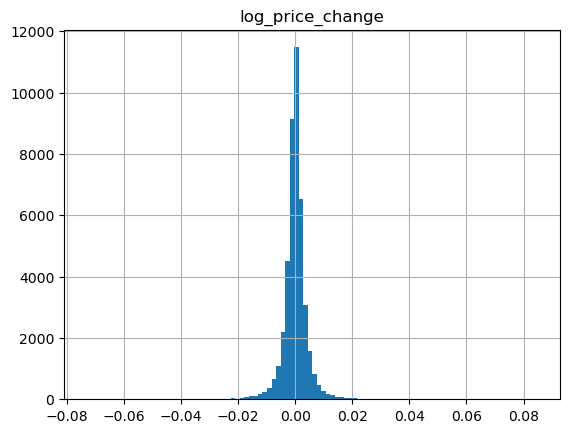

In [21]:
#Plot histogram of log_price_change with 1000 bin and title with plotlib
df["log_price_change"].hist(bins=100).set_title("log_price_change")

Text(0.5, 1.0, 'log_price_change')

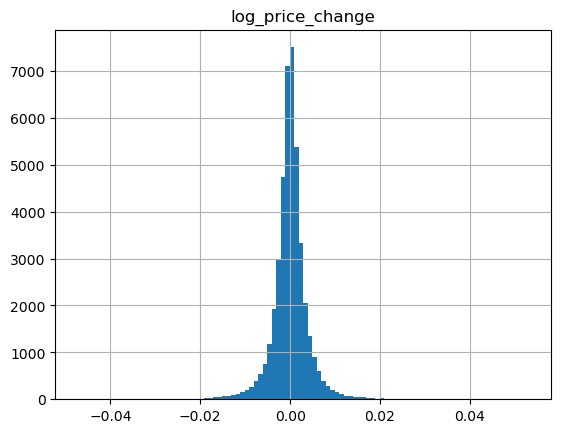

In [22]:
# Plot histogram of log_price_change with 1000 bin and fall under 99% percentile and title with plotlib
df["log_price_change"].hist(bins=100, range=(df["log_price_change"].quantile(0.0001), df["log_price_change"].quantile(0.9999))).set_title("log_price_change")

In [23]:
math.exp(0.02)

1.0202013400267558

In [24]:
df.tail(20)

,open,high,low,close,volume,prev_close,price_change,log_price_change,log_price_change2
timestamp,,,,,,,,,
2023-03-31 19:00:00,1822.87,1824.67,1818.54,1822.68,173.620502,1822.86,0.999901,-0.000099,-0.000099
2023-03-31 19:15:00,1822.68,1824.02,1820.22,1823.20,132.567886,1822.68,1.000285,0.000285,0.000285
2023-03-31 19:30:00,1823.59,1830.84,1823.59,1827.16,133.567876,1823.20,1.002172,0.002170,0.002170
2023-03-31 19:45:00,1827.24,1830.26,1826.47,1829.42,35.556076,1827.16,1.001237,0.001236,0.001236
2023-03-31 20:00:00,1829.46,1829.47,1824.58,1825.18,24.639109,1829.42,0.997682,-0.002320,-0.002320
2023-03-31 20:15:00,1825.01,1825.01,1819.21,1820.97,253.731151,1825.18,0.997693,-0.002309,-0.002309
2023-03-31 20:30:00,1821.65,1825.22,1819.20,1824.12,1142.384228,1820.97,1.001730,0.001728,0.001728
2023-03-31 20:45:00,1823.55,1826.00,1815.01,1817.68,444.809374,1824.12,0.996470,-0.003537,-0.003537
2023-03-31 21:00:00,1817.79,1818.78,1815.26,1818.77,142.042158,1817.68,1.000600,0.000599,0.000599
